In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../src')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops
from paretoviz.decorator import Arrow3D

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
# rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

<IPython.core.display.Javascript object>


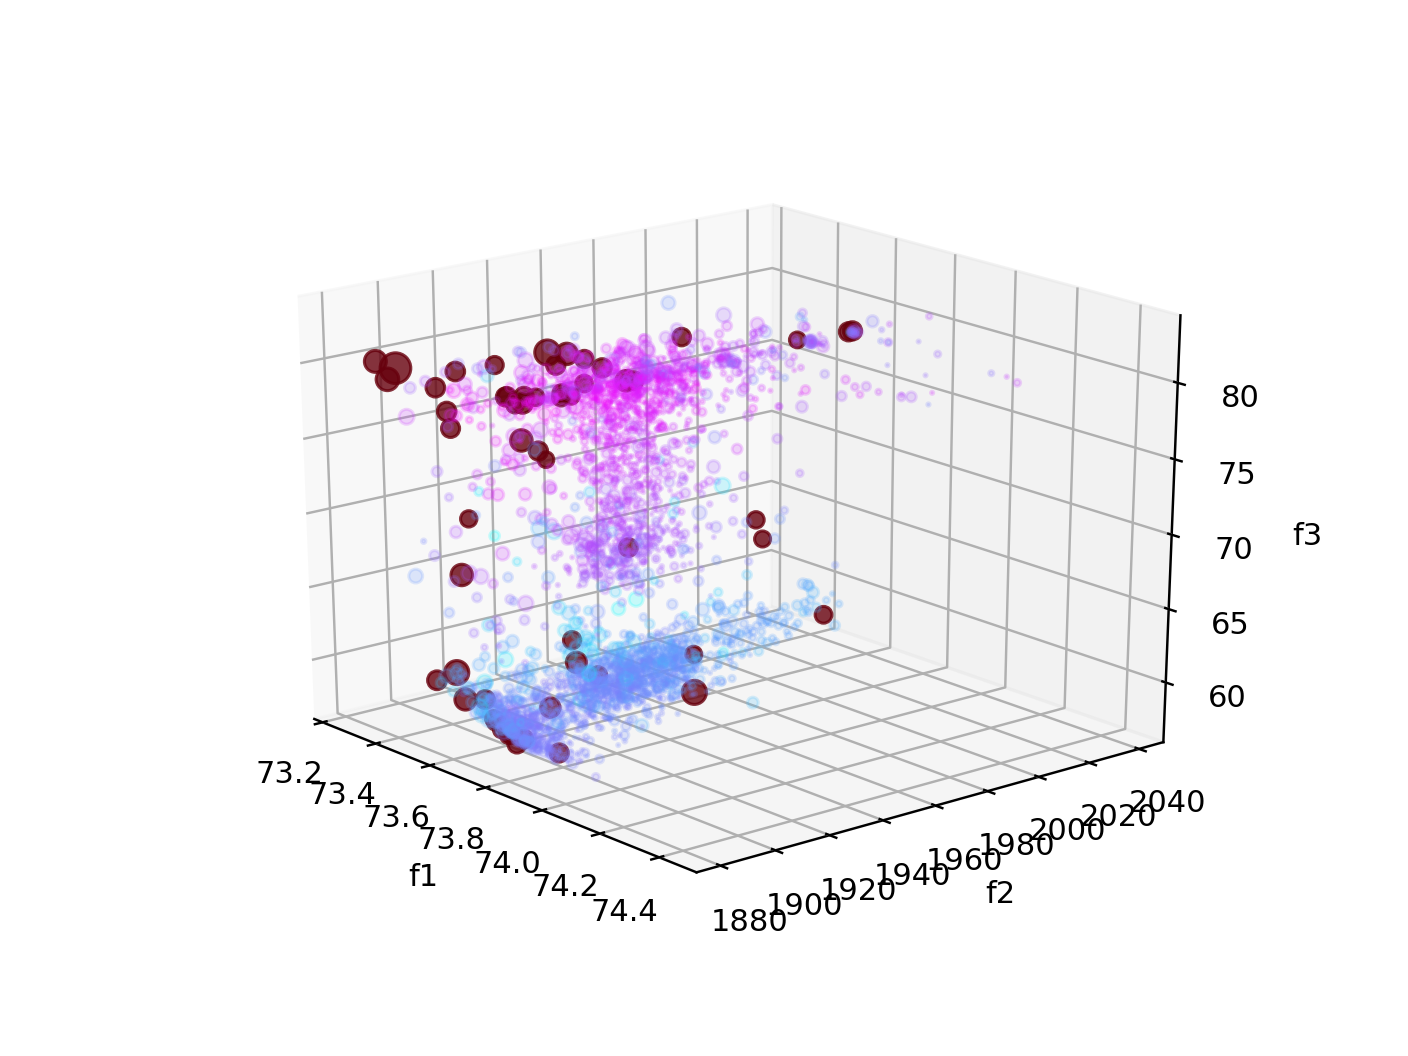

In [2]:
# use the original obj values for scatter plot.
rawpoints = fmt.load(rawfpath)
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx, \
                label = r"f{:d}", fontsize = 'medium')

# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
plt.savefig(scatterfpath, transparent = False, dpi = 300)

plt.show()

<IPython.core.display.Javascript object>


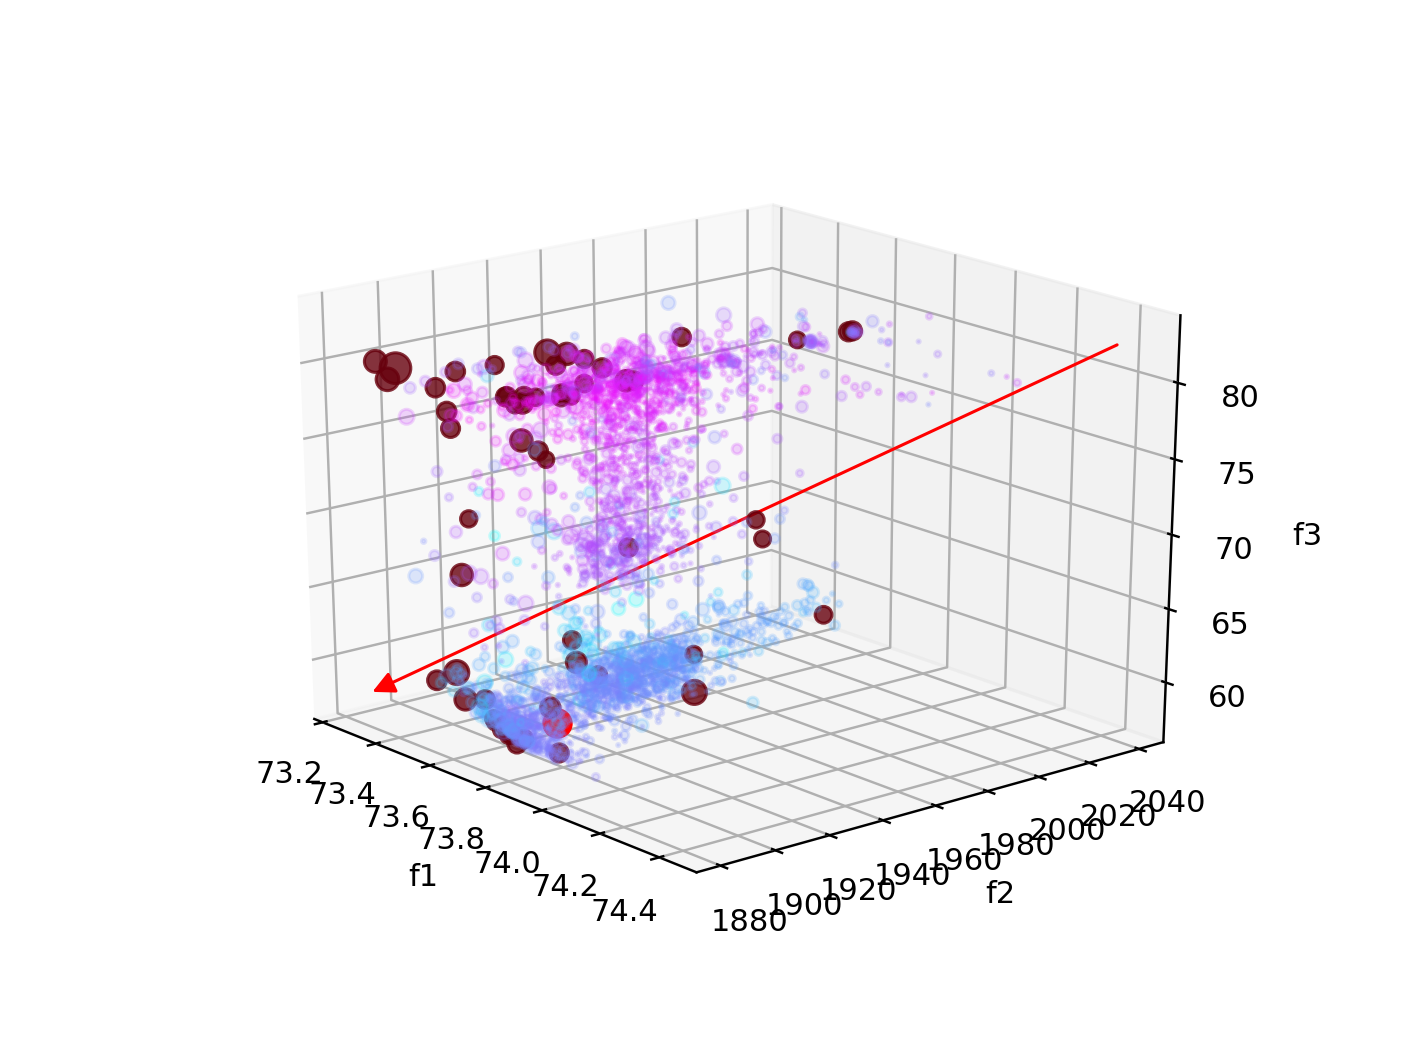

[0.000327333760520103, 0.04310672450089301, 0.006874570634673127, 3.96684016273662e-05, 0.034207840236874815, 0.7576622655216041, 0.15147545668427198, 0.0006450306991455459, 0.004636658770970382, 0.0010244507894195435]


In [3]:
import math
import numpy as np

# function for computing asf
def asf(f, z, w, rho = 0.0001):
    m = len(f)
    s, maxd = 0.0, float('-inf')
    for i in range(m):
        d = (f[i] - z[i]) / w[i]
        if d >= maxd:
            maxd = d
        s = s + d
    return maxd + (rho * s)

# Find the minimum ASF among all objective vectors
def minimize_asf(F, z, w, rho = 0.0001):
    minasf = [-1, float('inf')]
    for i,f in enumerate(F):
        asfv = asf(f, z, w, rho = rho)
        if asfv <= minasf[1]:
            minasf = [i, asfv]
    return minasf[0]

def minimize_dist(F, z):
    mindist = [-1, float('inf')]
    for i,f in enumerate(F):
        minv = vops.distlp(f, z)
        if minv <= mindist[1]:
            mindist = [i, minv]
    return mindist[0]

# First do a scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx, \
                label = "f{:d}", fontsize = 'medium')

# find the ideal and nadir points
refd = []
[utopia, nadir] = vops.get_bound(rawpoints)
refd.append([nadir, utopia])
if len(rawpoints[0]) == 3:
    refd.append([[0.0, 0.0, 1.0], [0.33, 0.33, 0.0]])
    refd.append([[0.33, 0.33, 0.0], [0.0, 0.0, 1.0]])
elif len(rawpoints[0]) == 4:
    refd.append([utopia, nadir])
    refd.append([[0.0, 0.0, 0.2, 0.3], [0.15, 0.15, 0.0, 0.0]])
    refd.append([[0.15, 0.15, 0.0, 0.0], [0.0, 0.0, 0.2, 0.3]])

arrclr = ['red', 'green', 'blue', 'black']
for i,d in enumerate(refd):
    v = vops.sub(d[0], d[1])
    u = [math.fabs(x) for x in v]
    su = math.fsum(u)
    w = [x/su for x in u]
    print(w)
    a = Arrow3D([d[0][0], d[1][0]], [d[0][1], d[1][1]], [d[0][2], d[1][2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = arrclr[i])
    ax.add_artist(a)

    j = minimize_asf(rawpoints, d[0], w, rho = 0.0)
    plt.scatter(rawpoints[j][0], rawpoints[j][1], zs = rawpoints[j][2], \
                c = arrclr[i], s = 80.0)

# # # save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-asf.pdf")
plt.savefig(scatterfpath, transparent = False, dpi = 300)
    
plt.show()

<IPython.core.display.Javascript object>


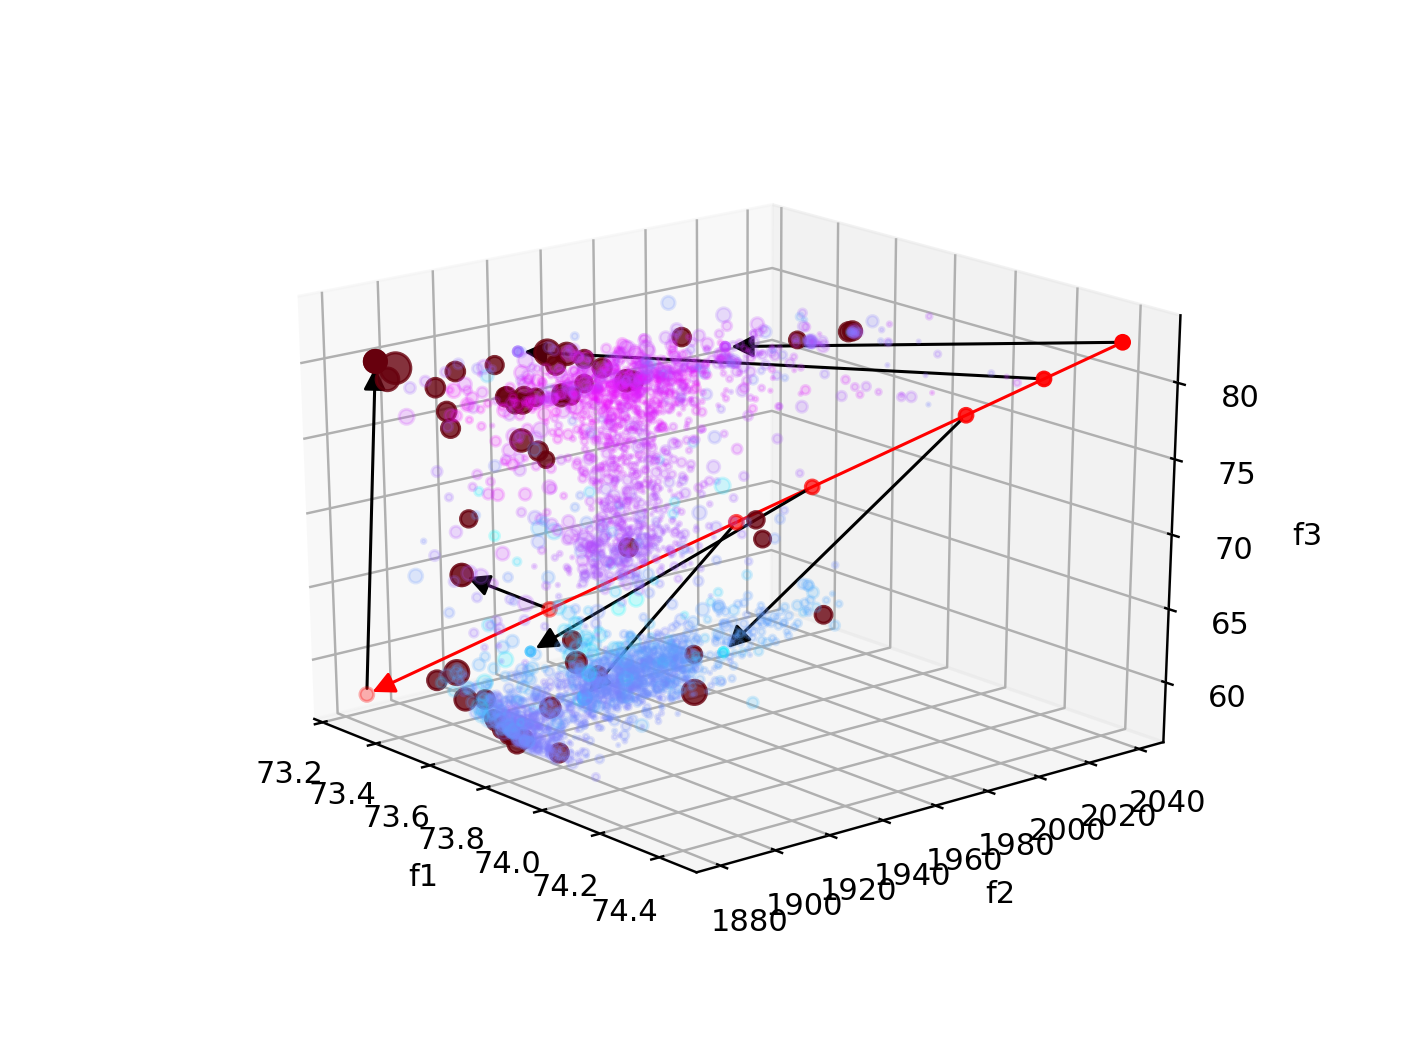

[1763, 903, 2983, 1153, 704, 1420, 2078]


In [4]:
# Swap the last objective of two vectors to make the plot more dramatic
def swap_last(nadir, utopia):
    tmp = utopia[-1]
    utopia[-1] = nadir[-1]
    nadir[-1] = tmp

# First do a scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx, \
                label = "f{:d}", fontsize = 'medium')

# find the ideal and nadir points
[utopia, nadir] = vops.get_bound(rawpoints)
swap_last(nadir, utopia)

# This is the direction that we want to go
a = Arrow3D([nadir[0], utopia[0]], [nadir[1], utopia[1]], [nadir[2], utopia[2]], \
            mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = 'red')
ax.add_artist(a)

v = vops.sub(utopia, nadir)
d = vops.distlp(utopia, nadir)
u = vops.unit(v)
w = [1.0] * len(rawpoints[0])
# scaling = [0.0, 0.25, 0.5, 0.75, 1.0]
# scaling = [0.0, 0.25, 0.5, 0.75, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.5, 0.75, 1.0]
# scaling = [0.0, 0.25, 0.5, 0.75, 0.1, 0.125, 0.15, 0.175, 0.25, 0.275, 0.5, 0.75, 1.0]
# scaling = [0.0, 0.10, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 1.0]
scaling = [0.0, 0.1, 0.2, 0.4, 0.5, 0.75, 1.0]

# asf solutions
asfsoln = []
Z = []
rawpt = []
rawptc = []
rawptsz = []
for s in scaling:
    Zr = vops.add(nadir, vops.mult(u, d * s))
    Z.append(Zr)
    j = minimize_asf(rawpoints, Zr, w, rho = 0.0)
    rawpt.append(rawpoints[j])
    rawptc.append(color[j])
    rawptsz.append(size[j])
    asfsoln.append(j)
print(asfsoln)
    
Zp = np.array(Z)
rp = np.array(rawpt)
rpc = np.array(rawptc)
# rsz = 80.0
rsz = np.array(rawptsz)
    
plt.scatter(Zp[:, 0], Zp[:, 1], zs = Zp[:, 2], c = 'red', s = 20.0)
plt.scatter(rp[:, 0], rp[:, 1], zs = rp[:, 2], c = rpc, s = rsz)
for i,j in enumerate(asfsoln):
    a = Arrow3D([Zp[i][0], rawpoints[j][0]], \
                [Zp[i][1], rawpoints[j][1]], \
                [Zp[i][2], rawpoints[j][2]], \
                mutation_scale = 15, lw = 1, \
                arrowstyle = "-|>", color = 'black')
    ax.add_artist(a)

# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-path.pdf")
plt.savefig(scatterfpath, transparent = False, dpi = 300)
    
plt.show()

<IPython.core.display.Javascript object>


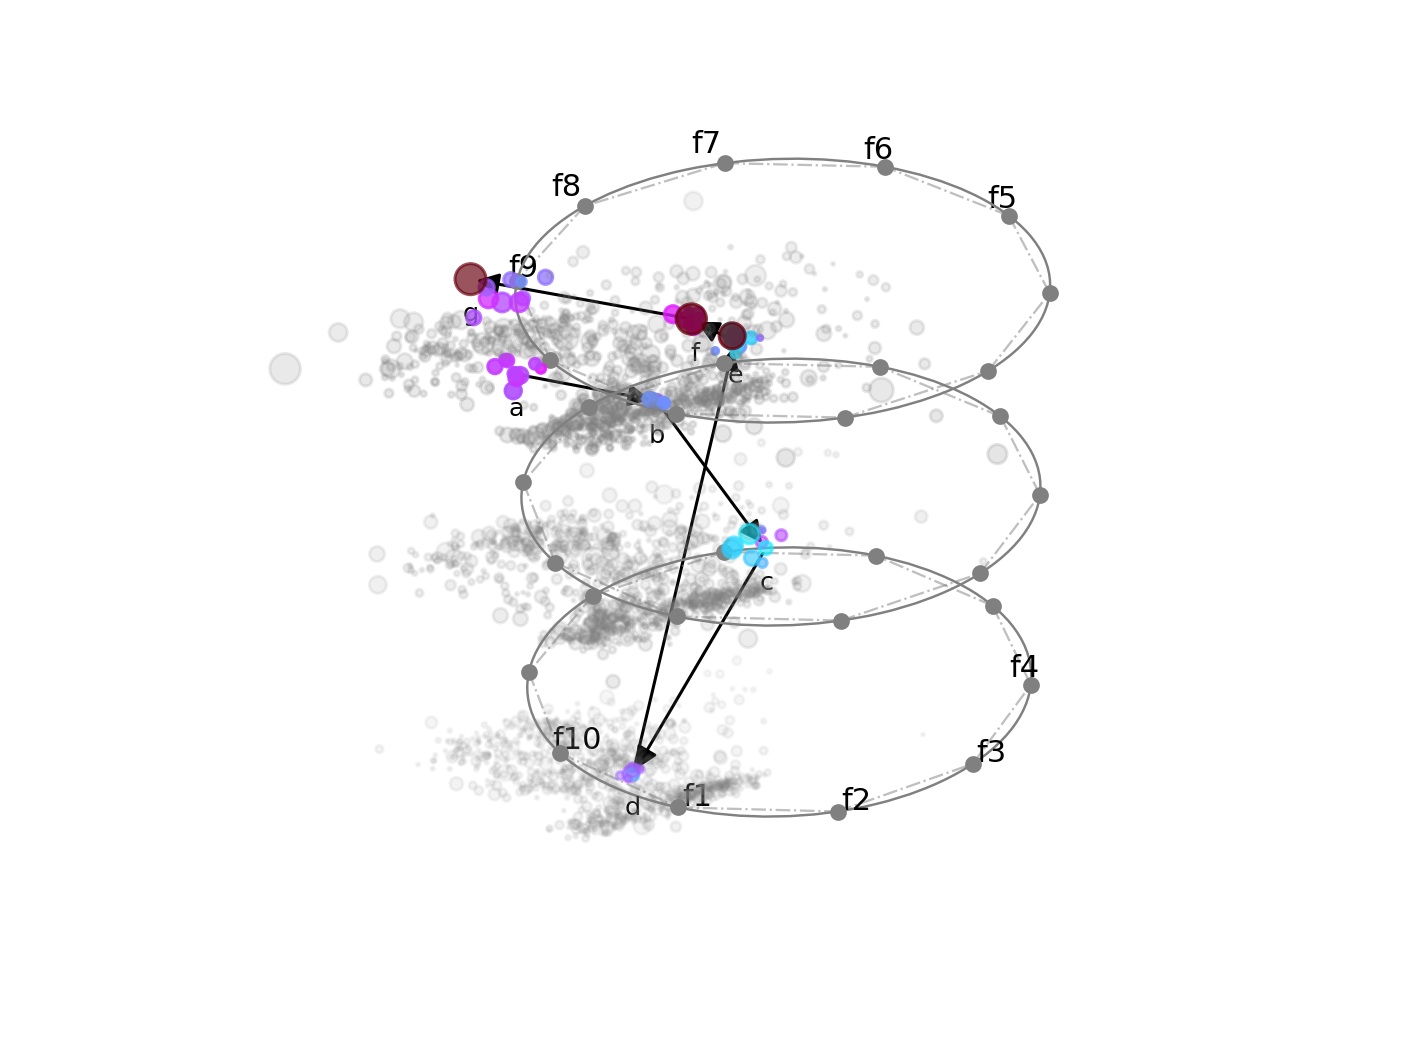

In [5]:
import string
import copy
from matplotlib import colors
from scipy import spatial

letters = list(string.ascii_lowercase)

# Show the generic paletteviz
palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))
tree = spatial.KDTree(np.array(palette_coords))

colorsln = copy.copy(asfsoln)
for i in range(len(asfsoln)):
    colorsln.append(asfsoln[i])
    (dist, index) = tree.query(palette_coords[asfsoln[i]], k = 10)
    for j in index:
        colorsln.append(j)

color_pr = []
size_pr = []
colorsln = set(colorsln)
for i in range(len(color)):
    if i not in colorsln:
        c = list(colors.to_rgba('grey'))
        c[-1] = 0.2 # alpha
        color_pr.append(tuple(c))
        size_pr.append(size[i])
    else:
        color_pr.append(color[i])
        # size_pr.append(80.0)
        size_pr.append(size[i] * 2.0)

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size_pr, c = color_pr, alpha = [None, None], \
            # camera = dcor.cam_palette[prefix], \
            camera = [41, 22], \
            knee_idx = knee_idx, mode = "sc", label = "f{:d}", fontsize = 'medium', \
            label_layers = {0: [5, 6, 7, 8, 9], -1: [1, 2, 3, 4, 10]})

# print(asfsoln)
j = 0
for i in range(len(asfsoln) - 1):
    from_ = palette_coords[asfsoln[i]]
    to_ = palette_coords[asfsoln[i+1]]
    # print("{0:d} --> {1:d}".format(i, i+1))
    a = Arrow3D([from_[0], to_[0]], [from_[1], to_[1]], [from_[2], to_[2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = "black")
    ax.add_artist(a)
    ax.text(from_[0] + 0.06, from_[1] + 0.06, z = from_[2] - 0.06, s = letters[j], \
            ha = 'right', va = 'top', size = 'small')
    j = j + 1        
        
from_ = palette_coords[asfsoln[-1]]
ax.text(from_[0] + 0.06, from_[1] + 0.06, z = from_[2] - 0.06, s = letters[j], \
                ha = 'right', va = 'top', size = 'small')

# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc-path.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0, dpi = 300)

plt.show()

In [28]:
import numpy as np
from scipy import spatial

def mpb(f, F, I_lt, I_ltz, I_eq, I_gt, I_not, Fmax, Fmin):
    I = []
    for i in range(F.shape[0]):
        if np.all(np.linalg.norm(F[i,I_eq[0]] - f[I_eq[0]]) <= I_eq[1]):
            I.append(i)
    print("len(I):", len(I))
    return f

F = np.array(rawpoints)
S = np.array(size)
C = np.array(color)
Ki = np.array(knee_idx)
Fmax = np.max(F, axis = 0)
Fmin = np.min(F, axis = 0)

I = [0.25, 0.25, -0.25, -0.25, 0.25, 0.25, -0.15, -0.15, 0, 0]

I_lt = [0, 1]
I_ltz = [[2, 3], 0.1]
I_eq = [[4, 5], 0.1]
I_gt = [[6, 7], 0.1]
I_not = [8, 9]

I_lt = [0, 1]
I_ltz = [[4, 5], 0.1]
I_eq = [[2, 3], 0.1]
I_gt = [[6, 7], 0.1]
I_not = [8, 9]

I_lt = [0, 1]
I_ltz = [[6, 7], 0.1]
I_eq = [[2, 3], 0.1]
I_gt = [[4, 5], 0.1]
I_not = [8, 9]

# change the decision making on every step.
# also use the entire solution set at every step since the decision is changing.
# instead of 3.2 use weighted sum of f and find a minimum

tree = spatial.KDTree(F)

# step 1
p = np.random.choice(np.arange(0, F.shape[0]))
# 2014, 2217, 263
print(p)
N = 10
Fh = np.zeros((N, F.shape[1]))
Fhi = np.zeros(N, dtype = 'int')
FhS = np.zeros(N)
FhC = np.zeros((N, 4))
for i in range(10):
    print("p:", p)
    f = F[p]
    f = mpb(f, F, I_lt, I_ltz, I_eq, I_gt, I_not, Fmax, Fmin)
    print("Fmax - Fmin:\n", Fmax - Fmin)
    fh_ = f + (I * (Fmax - Fmin))
    print("fh_:\n", fh_)
    (d,j) = tree.query(fh_)
    print("j:", j)
    Fh[i] = F[j]
    Fhi[i] = j
    FhS[i] = size[j]
    FhC[i] = color[j]
    p = j
    
print(Fh)

263
p: 263
len(I): 52
Fmax - Fmin:
 [1.18307000e+00 1.55799000e+02 2.48465000e+01 1.43372000e-01
 1.23636100e+02 2.73839000e+03 5.47472000e+02 2.33131000e+00
 1.67581000e+01 3.70263365e+00]
fh_:
 [ 7.42206175e+01  1.92385775e+03  5.23874750e+01  1.96365200e+00
  4.81198625e+02  4.33030975e+04 -2.08677480e+03 -1.61818365e+01
 -2.01472100e+02  9.68044000e-01]
j: 264
p: 264
len(I): 62
Fmax - Fmin:
 [1.18307000e+00 1.55799000e+02 2.48465000e+01 1.43372000e-01
 1.23636100e+02 2.73839000e+03 5.47472000e+02 2.33131000e+00
 1.67581000e+01 3.70263365e+00]
fh_:
 [ 7.41067875e+01  1.96837275e+03  5.33946550e+01  1.96410000e+00
  4.62059625e+02  4.40002575e+04 -2.14664480e+03 -1.61503865e+01
 -1.98337700e+02  4.01648800e-01]
j: 590
p: 590
len(I): 13
Fmax - Fmin:
 [1.18307000e+00 1.55799000e+02 2.48465000e+01 1.43372000e-01
 1.23636100e+02 2.73839000e+03 5.47472000e+02 2.33131000e+00
 1.67581000e+01 3.70263365e+00]
fh_:
 [ 7.40505575e+01  2.03509175e+03  7.50121150e+01  1.96415700e+00
  4.80887225e

<IPython.core.display.Javascript object>


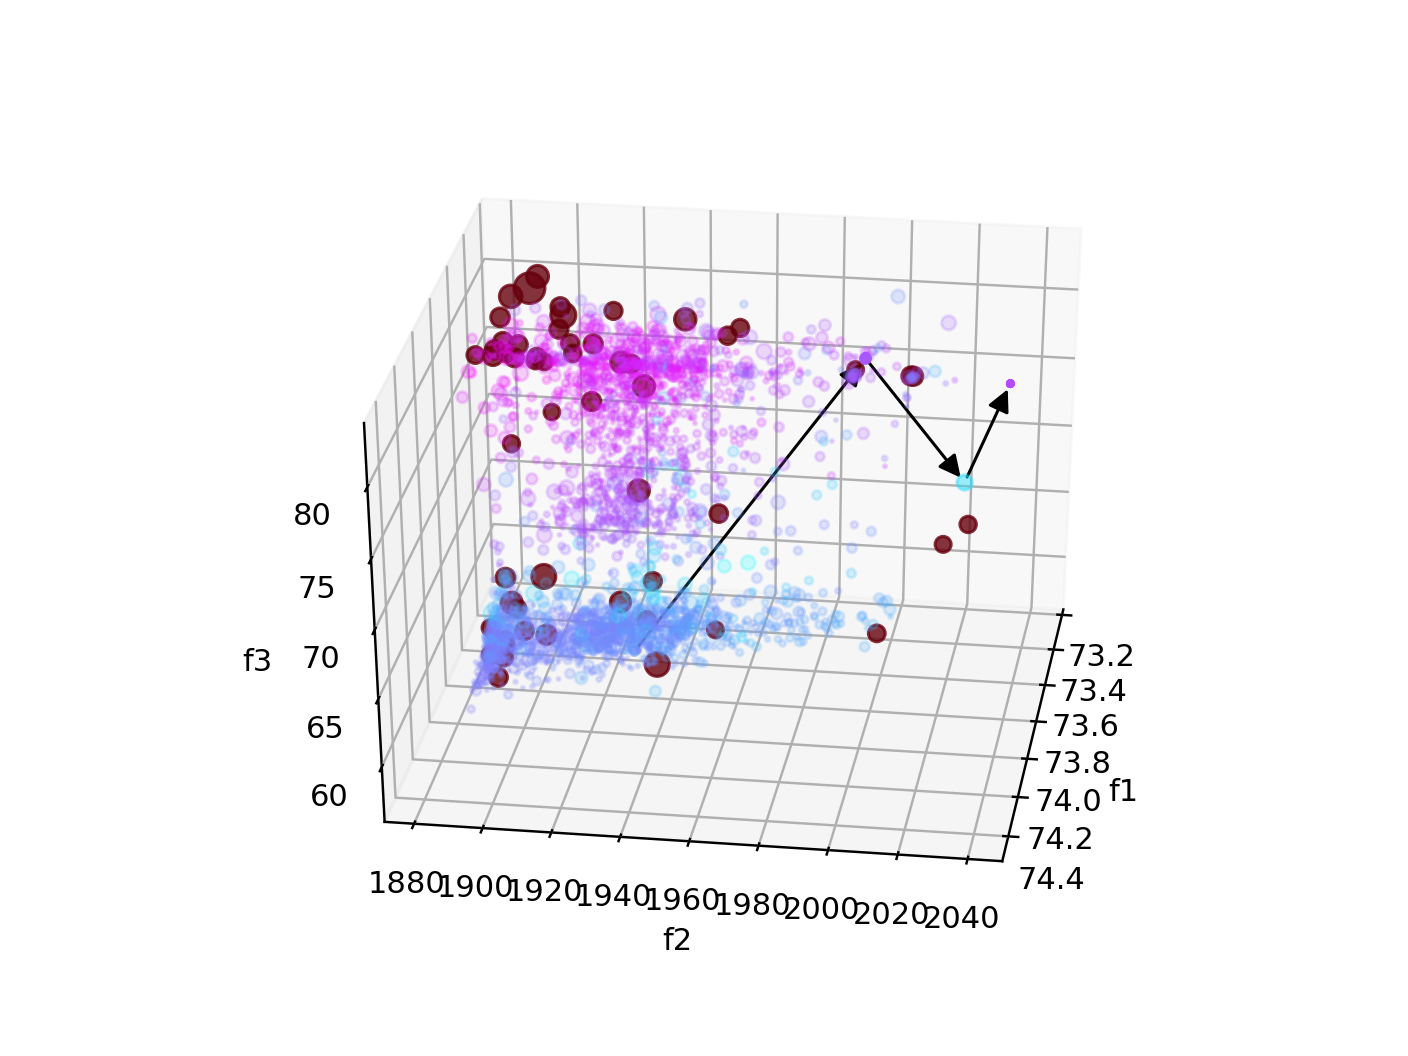

In [29]:
# First do a scatter plot
(fig, ax) = pplt.scatter(F.tolist(), s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx, \
                label = "f{:d}", fontsize = 'medium')

rp = Fh
rpc = FhC
# rsz = 80.0
rsz = FhS
    
# plt.scatter(Zp[:, 0], Zp[:, 1], zs = Zp[:, 2], c = 'red', s = 20.0)
plt.scatter(rp[:, 0], rp[:, 1], zs = rp[:, 2], c = rpc, s = rsz)
for i in range(Fh.shape[1]-1):
    a = Arrow3D([Fh[i][0], Fh[i+1][0]], \
                [Fh[i][1], Fh[i+1][1]], \
                [Fh[i][2], Fh[i+1][2]], \
                mutation_scale = 15, lw = 1, \
                arrowstyle = "-|>", color = 'black')
    ax.add_artist(a)
    
plt.show()

<IPython.core.display.Javascript object>


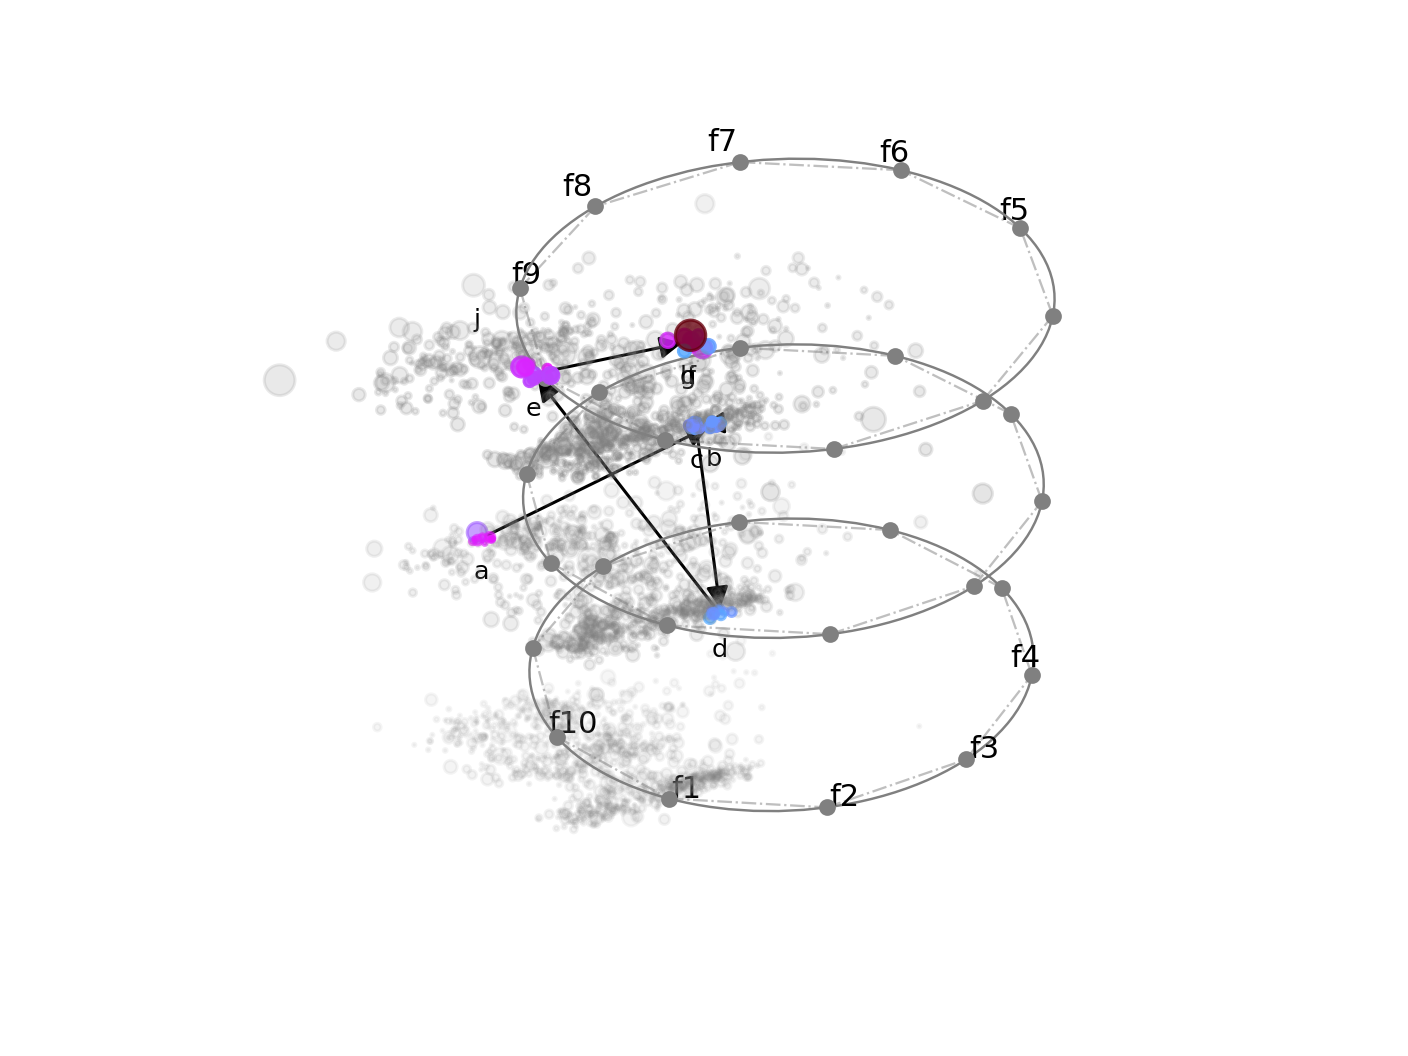

[2534 1107 1081 2859  159  372  372  372  372  372]


In [22]:
import string
import copy
from matplotlib import colors
from scipy import spatial

letters = list(string.ascii_lowercase)

# Show the generic paletteviz
palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))
tree = spatial.KDTree(np.array(palette_coords))

colorsln = copy.copy(Fhi.tolist())
for i in range(Fhi.shape[0]):
    colorsln.append(Fhi[i])
    (dist, index) = tree.query(palette_coords[Fhi[i]], k = 10)
    for j in index:
        colorsln.append(j)

color_pr = []
size_pr = []
colorsln = set(colorsln)
for i in range(len(color)):
    if i not in colorsln:
        c = list(colors.to_rgba('grey'))
        c[-1] = 0.2 # alpha
        color_pr.append(tuple(c))
        size_pr.append(size[i])
    else:
        color_pr.append(color[i])
        # size_pr.append(80.0)
        size_pr.append(size[i] * 2.0)

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size_pr, c = color_pr, alpha = [None, None], \
            # camera = dcor.cam_palette[prefix], \
            camera = [41, 22], \
            knee_idx = knee_idx, mode = "sc", label = "f{:d}", fontsize = 'medium', \
            label_layers = {0: [5, 6, 7, 8, 9], -1: [1, 2, 3, 4, 10]})

# print(asfsoln)
print(Fhi)
j = 0
for i in range(Fhi.shape[0] - 1):
    from_ = palette_coords[Fhi[i]]
    to_ = palette_coords[Fhi[i+1]]
    # print("{0:d} --> {1:d}".format(i, i+1))
    a = Arrow3D([from_[0], to_[0]], [from_[1], to_[1]], [from_[2], to_[2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = "black")
    ax.add_artist(a)
    ax.text(from_[0] + 0.06, from_[1] + 0.06, z = from_[2] - 0.06, s = letters[j], \
            ha = 'right', va = 'top', size = 'small')
    j = j + 1        
        
from_ = palette_coords[asfsoln[-1]]
ax.text(from_[0] + 0.06, from_[1] + 0.06, z = from_[2] - 0.06, s = letters[j], \
                ha = 'right', va = 'top', size = 'small')
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
plt.show()